In [1]:
!pip install trdg

     |████████████████████████████████| 91.2 MB 23 kB/s              
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 17.3 MB 45.9 MB/s            
  Created wheel for diffimg: filename=diffimg-0.2.3-py3-none-any.whl size=4049 sha256=b60008b050230e8cc21c44b8406e9a0381fa007ad60d62004af9a8c5c7032e75
  Stored in directory: /root/.cache/pip/wheels/6c/5d/60/bde2a959be56bca572bd67d49ebd52844d2ef933e85601dfa9
Successfully built diffimg
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda

# Text Recognition using CRNN

The Convolutional Recurrent Neural Networks is the combination of two of the most prominent neural networks, ie CNN(convolutional neural network) followed by the RNN(Recurrent neural networks). 

It can used for tasks such as Optical Character Recognition

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from trdg.generators import GeneratorFromDict
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

# Data Generation and Prepration

In [3]:
images = []
labels = []

os.mkdir('text_images')
n_images = 50_000
generator = GeneratorFromDict(count=n_images)
for img, lbl in tqdm(generator, total=n_images):
    path = f'text_images/{lbl}.png'
    img.save(path)
    images.append(path)
    labels.append(lbl)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [4]:
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

downsample_factor = 4

characters = set(char for label in labels for char in label)
max_length = max([len(label) for label in labels])

print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
print("Maximum length of a word", max_length)

Number of unique characters:  55
Characters present:  {'x', 'r', "'", 'X', 'b', 'p', 'f', 'M', 'g', 'U', 'z', 'a', 'J', 'S', 'l', 'y', '.', 'H', '-', 'm', 's', 'v', 'i', 'P', 'N', 'F', 'D', 'k', 'Y', 'R', 'B', 'T', 'w', 'V', 'u', 'j', 'Z', 'h', 'o', 't', 'd', 'C', 'K', 'W', 'A', 'I', 'L', 'O', 'c', 'q', 'n', 'E', 'Q', 'G', 'e'}
Maximum length of a word 20


In [5]:
char_to_num = {char: idx+1 for idx, char in enumerate(sorted(characters))}
num_to_char = {idx+1:char for idx, char in enumerate(sorted(characters))}

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(images), np.array(labels), test_size=0.1)

In [7]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = pad_sequences(
        [[char_to_num[char] for char in label]], maxlen=img_width//downsample_factor, padding='post'
    )
    return {"image": img, "label": label}


In [8]:
train_images = []
train_labels = []
for img, lbl in zip(x_train, y_train):
    encoded = encode_single_sample(img, lbl)
    train_images.append(encoded['image'])
    train_labels.append(encoded['label'])
    
valid_images = []
valid_labels = []
for img, lbl in zip(x_valid, y_valid):
    encoded = encode_single_sample(img, lbl)
    valid_images.append(encoded['image'])
    valid_labels.append(encoded['label'])    

2022-03-01 08:52:07.829188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 08:52:07.919741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 08:52:07.920410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 08:52:07.923286: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

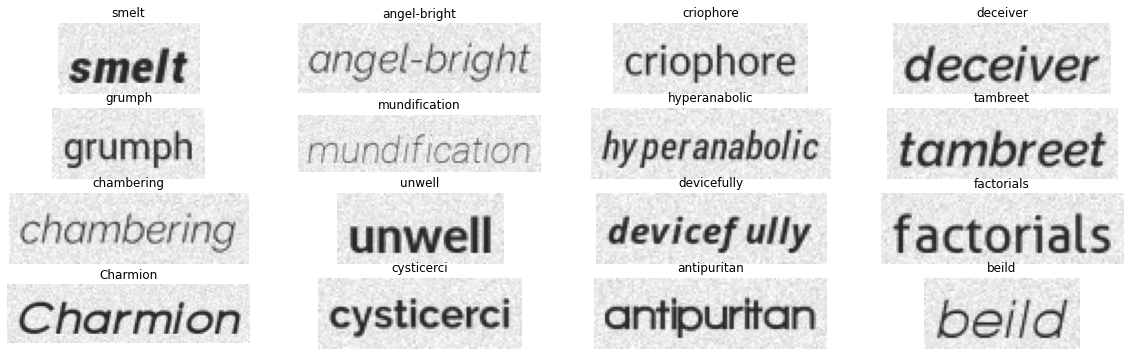

In [9]:
_, ax = plt.subplots(4, 4, figsize=(20, 6))
for i, (images, labels) in enumerate(zip(x_train[:16], y_train[:16])):
    ax[i // 4, i % 4].imshow(plt.imread(images), cmap="gray")
    ax[i // 4, i % 4].set_title(labels)
    ax[i // 4, i % 4].axis("off")
plt.show()

# Model

Model: "crnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            49216  

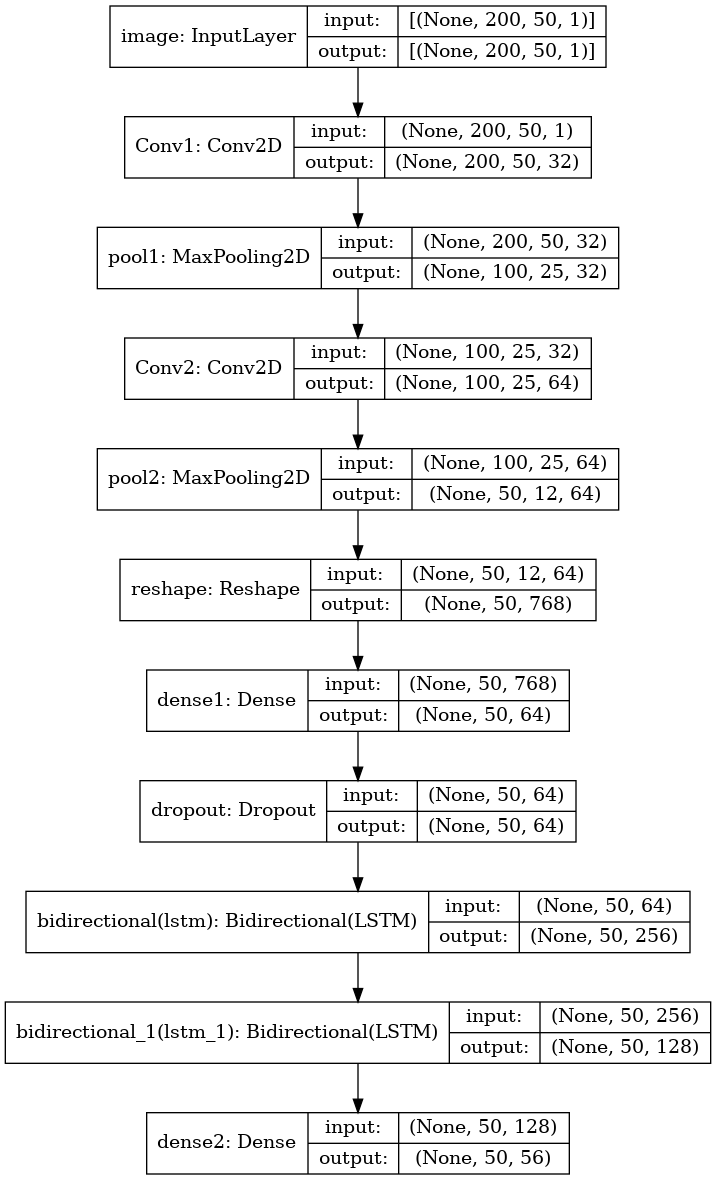

In [10]:
input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")

x = layers.Conv2D(
    32,
    (3, 3),
    activation="relu",
    padding="same",
    name="Conv1",
)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)

x = layers.Conv2D(
    64,
    (3, 3),
    activation="relu",
    padding="same",
    name="Conv2",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

new_shape = ((img_width // downsample_factor), (img_height // downsample_factor) * 64)
x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

output = layers.Dense(
    len(char_to_num) + 1, activation="softmax", name="dense2"
)(x)

model = keras.models.Model(
    inputs=input_img, outputs=output, name="crnn"
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()
keras.utils.plot_model(model, show_shapes=True)

# Training

In [11]:
epochs = 500
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True, verbose=1
)


history = model.fit(
    np.array(train_images), np.array(train_labels),
    validation_data=(np.array(valid_images), np.array(valid_labels)),
    epochs=epochs,
    callbacks=[early_stopping],
)

2022-03-01 08:53:11.942527: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1800000000 exceeds 10% of free system memory.
2022-03-01 08:53:13.912270: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1800000000 exceeds 10% of free system memory.
2022-03-01 08:53:15.225465: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-03-01 08:53:20.921991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1407/1407 [==============================] - 39s 20ms/step - loss: 0.6266 - val_loss: 0.5712
Epoch 2/500
1407/1407 [==============================] - 26s 19ms/step - loss: 0.5345 - val_loss: 0.4643
Epoch 3/500
1407/1407 [==============================] - 26s 19ms/step - loss: 0.4137 - val_loss: 0.3394
Epoch 4/500
1407/1407 [==============================] - 27s 19ms/step - loss: 0.3023 - val_loss: 0.2114
Epoch 5/500
1407/1407 [==============================] - 26s 19ms/step - loss: 0.2196 - val_loss: 0.1341
Epoch 6/500
1407/1407 [==============================] - 26s 19ms/step - loss: 0.1630 - val_loss: 0.0813
Epoch 7/500
1407/1407 [==============================] - 26s 19ms/step - loss: 0.1225 - val_loss: 0.0531
Epoch 8/500
1407/1407 [==============================] - 27s 19ms/step - loss: 0.0942 - val_loss: 0.0328
Epoch 9/500
1407/1407 [==============================] - 27s 19ms/step - loss: 0.0736 - val_loss: 0.0266
Epoch 10/500
1407/1407 [==============================] - 26s 19ms/

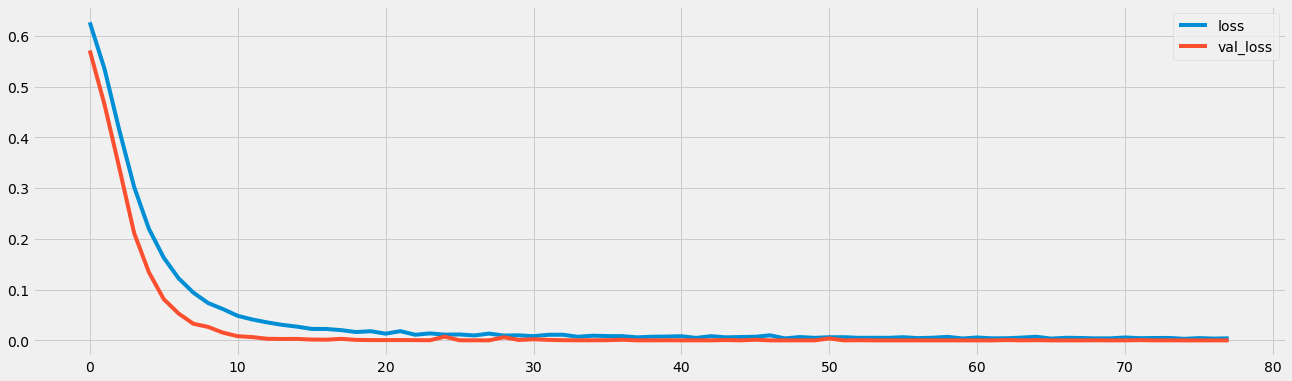

In [12]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).plot(ax=ax);

# Inference

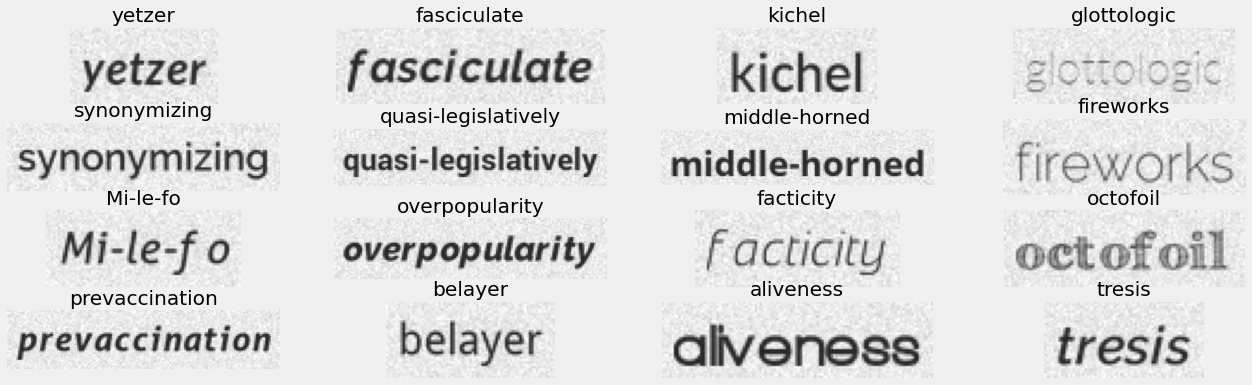

In [13]:
y_preds = model(np.array(valid_images)[:16]).numpy().argmax(axis=-1)
y_preds = [''.join([num_to_char.get(num, '') for num in pred]) for pred in y_preds]

_, ax = plt.subplots(4, 4, figsize=(20, 6))
for i, (images, labels) in enumerate(zip(x_valid[:16], y_preds[:16])):
    ax[i // 4, i % 4].imshow(plt.imread(images), cmap="gray")
    ax[i // 4, i % 4].set_title(labels)
    ax[i // 4, i % 4].axis("off")
plt.show()
